In [1]:
import os
os.chdir('../')

In [2]:
from core.general_dataset.base import GeneralizedDataset
from core.utils import yaml_read

def make_cfg(config, split):
    cfg = config.copy()
    cfg['split'] = split
    # disable sampling and augmentations for val/test
    if split in ('valid', 'test'):
        cfg['validate_road_ratio'] = False
        cfg['max_attempts'] = 1
        cfg['augmentations'] = []  # no augmentations
    return cfg

yaml_path = 'configs/dataset/AL175.yaml'
config = yaml_read(yaml_path)
dataset = GeneralizedDataset(make_cfg(config, 'train'))
print("Dataset length:", len(dataset))

→ Split 'train': 4 stems
     image   : 4 files
     label   : 4 files
     distance: 4 files
→ Split 'test': 1 stems
     label   : 1 files
     image   : 1 files
     distance: 1 files
→ Split 'valid': 1 stems
     image   : 1 files
     label   : 1 files
     distance: 1 files
Saved index for split 'train' to /home/ri/Desktop/Projects/Datasets/AL175-inds/train_index.json
Saved index for split 'test' to /home/ri/Desktop/Projects/Datasets/AL175-inds/test_index.json
Saved index for split 'valid' to /home/ri/Desktop/Projects/Datasets/AL175-inds/valid_index.json


Processing distance maps: 100%|██████████| 4/4 [00:00<00:00, 144.00it/s]

Dataset length: 4


_postprocess_patch beginning0 image 3 (253, 256, 240)
 _postprocess_patch beginningimage 4 (1, 253, 256, 240)
_postprocess_patch beginning0 label 3 (253, 256, 240)
_postprocess_patch beginning label 4 (1, 253, 256, 240)
_postprocess_patch beginning0 distance 3 (253, 256, 240)
_postprocess_patch beginning distance 4 (1, 253, 256, 240)
_postprocess_patch beginning0 image 3 (253, 256, 240)
_postprocess_patch beginning image 4 (1, 253, 256, 240)
_postprocess_patch beginning0 label 3 (253, 256, 240)
_postprocess_patch beginning label 4 (1, 253, 256, 240)
_postprocess_patch beginning0 distance 3 (253, 256, 240)
_postprocess_patch beginning distance 4 (1, 253, 256, 240)
_postprocess_patch beginning0 image 3 (253, 256, 240)
_postprocess_patch beginning image 4 (1, 253, 256, 240)
_postprocess_patch beginning0 label 3 (253, 256, 240)
_postprocess_patch beginning label 4 (1, 253, 256, 240)
_postprocess_patch beginning0 distance 3 (253, 256, 240)
_postprocess_patch beginning distance 4 (1, 253, 25

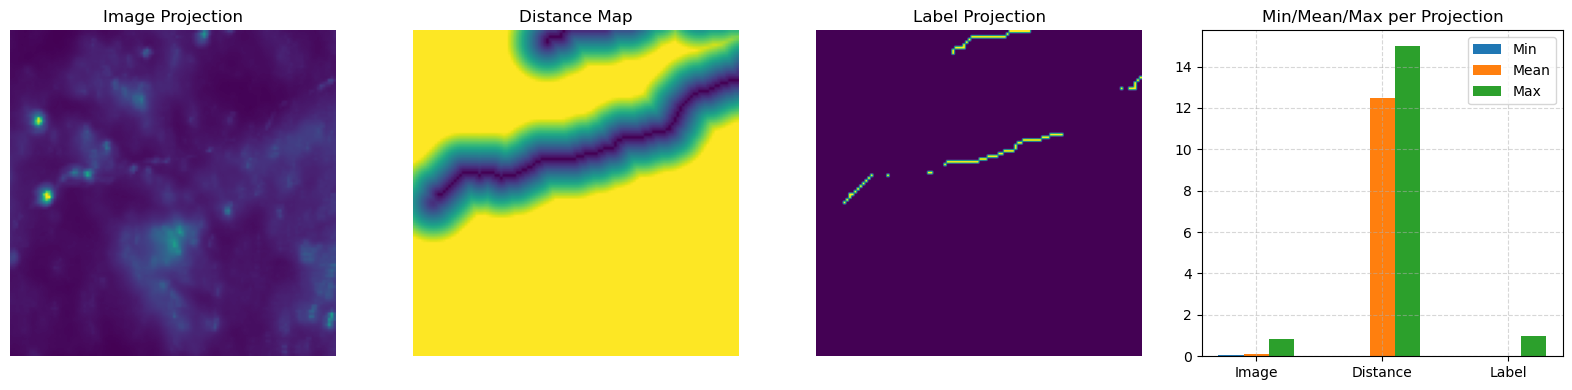

{'Image': (0.0016656921, 0.009057013, 0.0029846842), 'Distance': (15.0, 15.0, 15.0), 'Label': (0, 0, 0.0)}


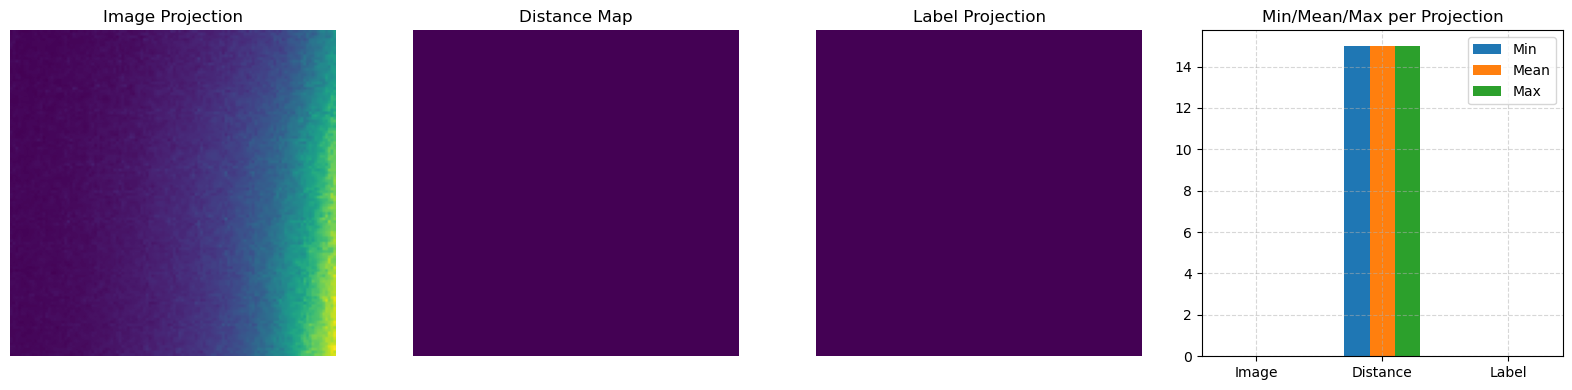

{'Image': (0.007797591, 0.9750599, 0.08198412), 'Distance': (11.045361, 15.0, 14.989639), 'Label': (0, 0, 0.0)}


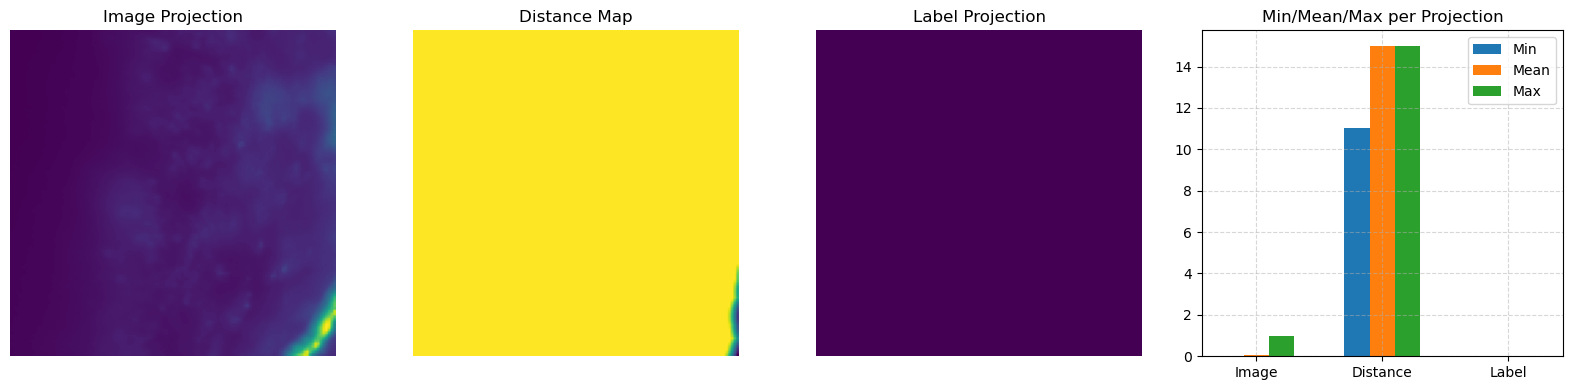

{'Image': (0.0016601349, 0.0028113408, 0.0019510512), 'Distance': (15.0, 15.0, 15.0), 'Label': (0, 0, 0.0)}


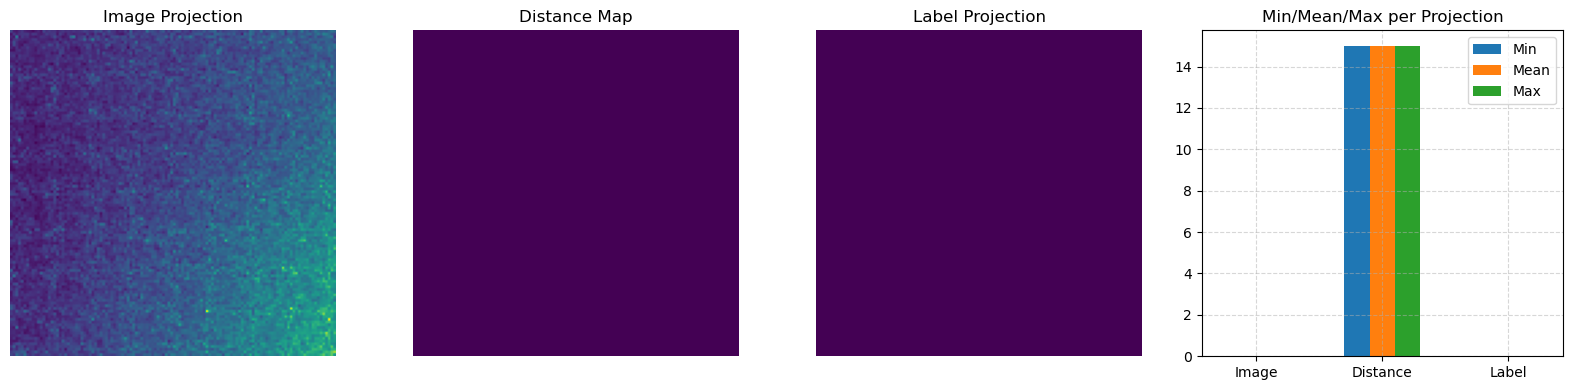

In [3]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np  

import matplotlib.pyplot as plt
import numpy as np

def plot_batch_with_stats(batch, slice_dim=2):
    """
    Plot image, distance label, and binary label projections side by side,
    plus a bar chart of their min, max, and mean statistics for each sample.
    
    Args:
        batch: dict with keys "image_patch", "distance_patch", "label_patch"
        slice_dim: axis along which to take the max/min projection (default: 2 for Z)
    """
    images = batch["image_patch"]
    distlbls = batch["distance_patch"]
    lbls = batch["label_patch"]

    for img, distlbl, lbl in zip(images, distlbls, lbls):
        # Projections
        img_proj  = img[0].numpy().max(slice_dim)
        dist_proj = distlbl[0].numpy().min(slice_dim)
        lbl_proj  = lbl[0].numpy().max(slice_dim)

        # Plot side by side images
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        for ax, proj, title in zip(
            axes[:3],
            (img_proj, dist_proj, lbl_proj),
            ("Image Projection", "Distance Map", "Label Projection"),
        ):
            ax.imshow(proj)
            ax.set_title(title)
            ax.axis("off")
        
        # Compute stats
        stats = {
            'Image': (img_proj.min(), img_proj.max(), img_proj.mean()),
            'Distance': (dist_proj.min(), dist_proj.max(), dist_proj.mean()),
            'Label': (lbl_proj.min(), lbl_proj.max(), lbl_proj.mean()),
        }
        print(stats)
        # Bar chart of stats
        categories = list(stats.keys())
        mins = [stats[k][0] for k in categories]
        maxs = [stats[k][1] for k in categories]
        means = [stats[k][2] for k in categories]
        
        x = np.arange(len(categories))
        width = 0.2
        
        ax_stats = axes[3]
        ax_stats.bar(x - width, mins,    width, label='Min')
        ax_stats.bar(x,         means,  width, label='Mean')
        ax_stats.bar(x + width, maxs,    width, label='Max')
        ax_stats.set_xticks(x)
        ax_stats.set_xticklabels(categories)
        ax_stats.set_title('Min/Mean/Max per Projection')
        ax_stats.legend()
        ax_stats.grid(True, linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()

# Usage:
# batch = next(iter(loader))
# plot_batch_with_stats(batch)


def plot_3d_volume(volume, threshold, greater_is_road=False):
    plt.ion()
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    if greater_is_road:
        x, y, z = np.where(volume > threshold)
    else:
        x, y, z = np.where(volume <= threshold)
    ax.scatter(x, y, z, c=volume[x, y, z], cmap='viridis', marker='o', alpha=0.5)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    plt.show()


loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)

batch = next(iter(loader))

print(f'Images: {batch["image_patch"].shape}, Label: {batch["label_patch"].shape}')

# for img, distlbl, lbl in zip(batch["image_patch"], batch["distance_patch"], batch["label_patch"]):
#     print(img.shape, lbl.shape)
#     # plot_3d_volume(img[0].numpy(), threshold=0, greater_is_road=False)
#     # plot_3d_volume(lbl[0].numpy(), threshold=0, greater_is_road=True)
#     plt.imshow(img[0].numpy().max(2))
#     plt.show()
#     plt.imshow(distlbl[0].numpy().min(2))#, cmap='coolwarm')
#     plt.show()
#     plt.imshow(lbl[0].numpy().max(2))
#     plt.show()
# batch = next(iter(loader))
plot_batch_with_stats(batch)



/home/ri/miniconda3/envs/dl/lib/python3.9/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


{'Image': (0.0015869382772564279, 0.0020752269779507134, 0.001681042201792088), 'Distance': (15.0, 15.0, 15.0), 'Label': (0, 0, 0.0)}


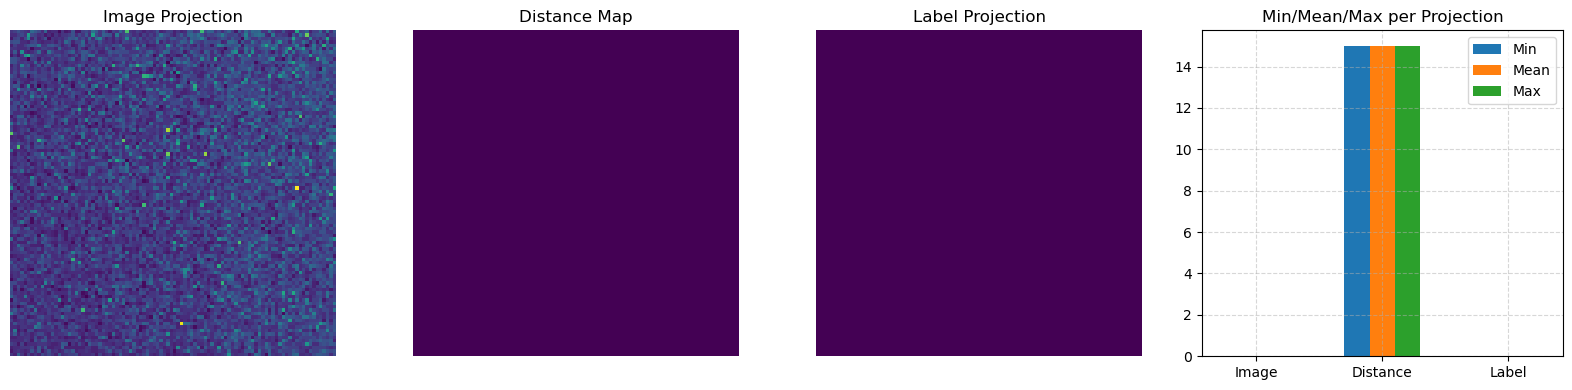

{'Image': (0.0016021972991531242, 0.00247196154726482, 0.0017460933857438353), 'Distance': (15.0, 15.0, 15.0), 'Label': (0, 0, 0.0)}


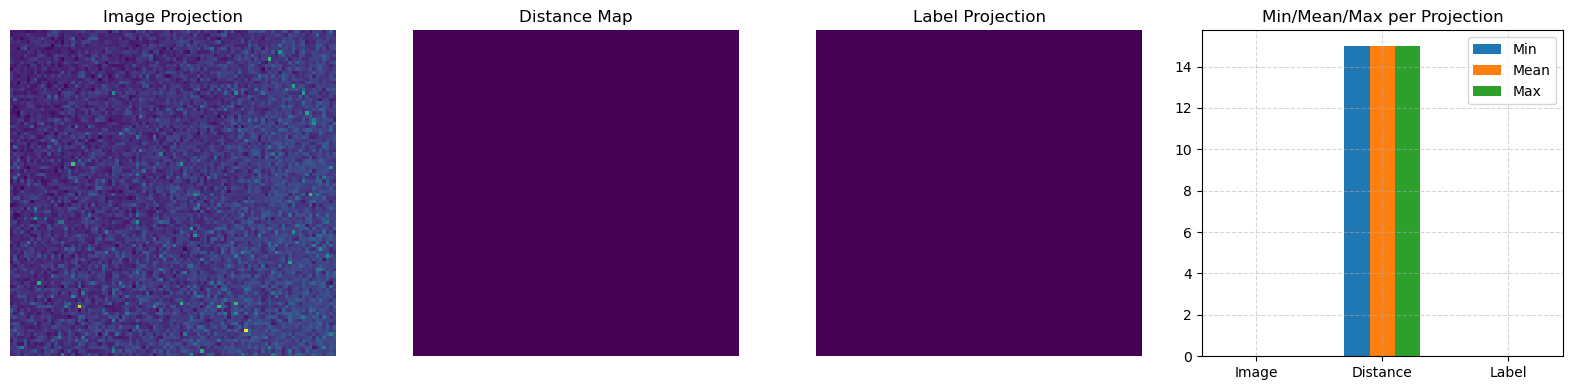

{'Image': (0.06959639887083238, 1.0, 0.1867495180559794), 'Distance': (0.0, 15.0, 6.475169), 'Label': (0, 1, 0.04123263888888889)}


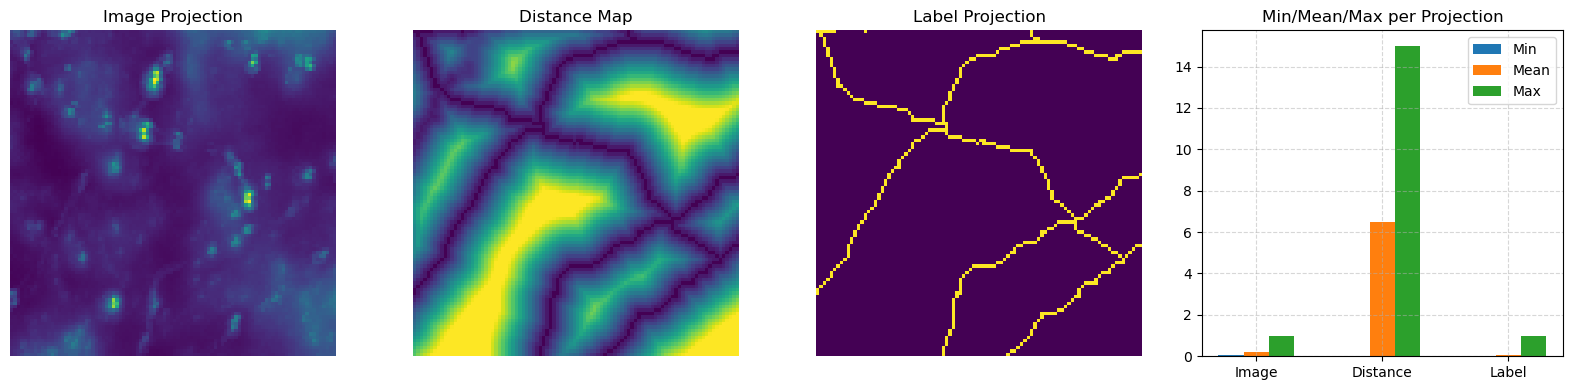

{'Image': (0.0016937514305333029, 0.0023346303501945525, 0.0018617529967023562), 'Distance': (15.0, 15.0, 15.0), 'Label': (0, 0, 0.0)}


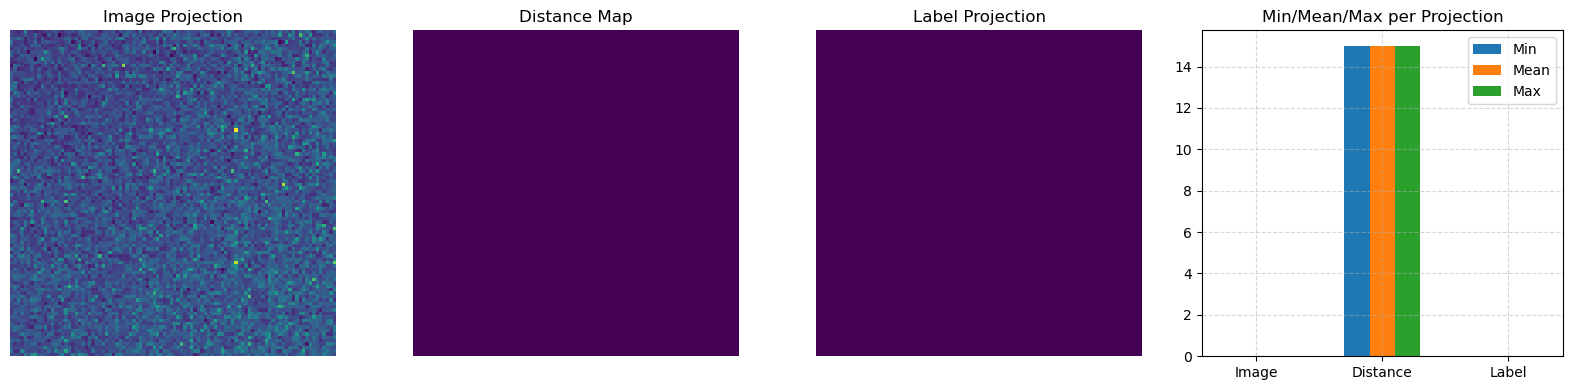

In [9]:
batch = next(iter(loader))
plot_batch_with_stats(batch)


In [50]:
pred = np.load('AllFayzad/val_e999_b13_i0_pred.npy')
gt = np.load('AllFayzad/val_e9_b13_i0_gt.npy')

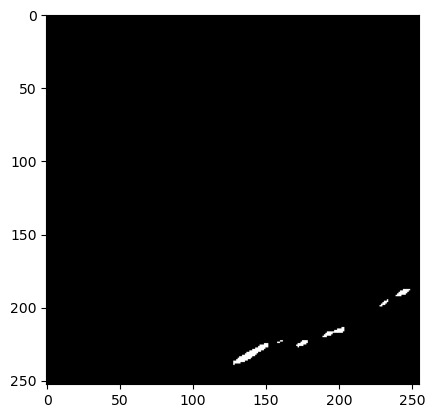

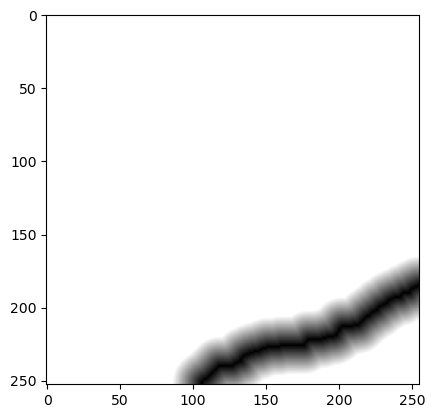

In [52]:
plt.imshow(pred[0].min(2)<2, cmap='gray')
plt.show()
plt.imshow(gt[0].min(2), cmap='gray')
plt.show()

In [1]:
import os
os.chdir('../')

In [2]:
from copy import deepcopy
from core.general_dataset.augmentations import augment_images
import numpy as np

rng_global = np.random.RandomState(0)
dummy = {'image': rng_global.rand(1, 96, 96)}

cfg = {'flip_h': {'modalities':['image'], 'prob':1.0}}
out1 = augment_images(deepcopy(dummy), 'flip_h', cfg['flip_h'], 2, rng_global)
out2 = augment_images(deepcopy(dummy), 'flip_h', cfg['flip_h'], 2, rng_global)
assert np.array_equal(out1['image'], out2['image'])   # Always true with current code


In [5]:
import torch
from core.general_dataset.base import GeneralizedDataset
from core.utils import yaml_read

yaml_path = 'configs/dataset/AL175_15.yaml'
config = yaml_read(yaml_path)
ds = GeneralizedDataset({**config, "split":"valid"})
# ds = GeneralizedDataset({**config, "split":"train"})
x = ds[0]
assert all(torch.is_tensor(v) for v in x.values())


→ Split 'train': 4 stems
     image   : 4 files
     label   : 4 files
     distance: 4 files
→ Split 'test': 1 stems
     label   : 1 files
     image   : 1 files
     distance: 1 files
→ Split 'valid': 1 stems
     image   : 1 files
     label   : 1 files
     distance: 1 files
Saved index for split 'train' to /home/ri/Desktop/Projects/Datasets/AL175-inds/train_index.json
Saved index for split 'test' to /home/ri/Desktop/Projects/Datasets/AL175-inds/test_index.json
Saved index for split 'valid' to /home/ri/Desktop/Projects/Datasets/AL175-inds/valid_index.json


Processing distance maps: 100%|██████████| 1/1 [00:00<00:00, 55.89it/s]


In [6]:
assert all(torch.is_tensor(v) for v in x.values())
print({k: v.shape for k,v in x.items()})

{'image_patch': torch.Size([1, 253, 256, 240]), 'label_patch': torch.Size([1, 253, 256, 240]), 'distance_patch': torch.Size([1, 253, 256, 240])}


In [ ]:
import torch, kornia as K

# single image (C,H,W) → make it a batch (B=1)
img = torch.rand(1, 3, 256, 256)

# rotate 30° CCW in the image plane
rotated = K.geometry.transform.rotate(img, angle=torch.tensor([30.0]))
# returns shape (1,3,256,256)
